  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting content/cifar-10-python.tar.gz to content
Files already downloaded and verified


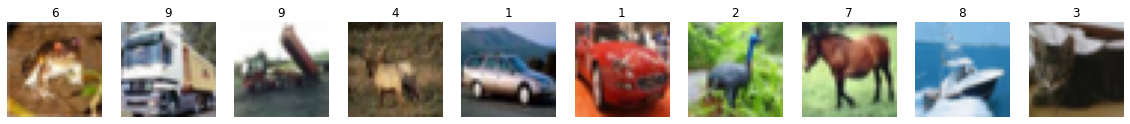

In [1]:
# Load dataset in Pytorch dataset class

from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

trainset = datasets.CIFAR10("content", train=True, download=True)
testset = datasets.CIFAR10("content", train=False, download=True)

# Display some samples
for j in range(10):
  image, class_num = trainset[j]
  plt.subplot(1, 10, j+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(str(class_num))

In [2]:
# Validation function. Don't change it
def validate(model, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  return correct / total

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class TwoLayerFCN(nn.Module):
  def __init__(self, class_num=10, middle_layer=128, activation_function=nn.ReLU):
    super(TwoLayerFCN, self).__init__()
    # Define two layer fully-connected network with linear layers:
    # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    
    self.flatten = nn.Flatten()
    self.lin_1 = nn.Linear(32*32*3, middle_layer)
    self.activation = activation_function()
    self.lin_2 = nn.Linear(middle_layer, class_num)

  def forward(self, x):
    x = self.flatten(x)
    x = self.lin_1(x)
    x = self.activation(x)
    x = self.lin_2(x)
    return x


In [4]:
# prepare the data
transform = transforms.Compose([
  transforms.ToTensor(), # pil image to pytorch tensor
  # https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.normalize
  transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
])

trainset.transform = transform
testset.transform = transform

train_loader = DataLoader(trainset, batch_size=512, shuffle=True)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

In [6]:
# Train the model
# You may change loss function, learning rate and number of epochs

model = TwoLayerFCN(10) 
model.train()

# By default cross-entropy loss used, you can change it to another loss function
criterion = nn.CrossEntropyLoss() 

# You can change learning rate and number of epoch too
optimizer = torch.optim.SGD(model.parameters(), lr=0.005) 
for epoch in range(25):
  for img_batch, labels_batch in train_loader:
    optimizer.zero_grad()
    output = model(img_batch)
    loss = criterion(output, labels_batch)
    # Get the grad and update model weights: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#backprop
    
    loss.backward()
    optimizer.step()

  accuracy = validate(model, test_loader)
  print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch, loss.item(), accuracy))
  

Epoch 0 Loss 1.99 Accuracy 0.30
Epoch 1 Loss 1.92 Accuracy 0.34
Epoch 2 Loss 1.79 Accuracy 0.36
Epoch 3 Loss 1.86 Accuracy 0.38
Epoch 4 Loss 1.73 Accuracy 0.39
Epoch 5 Loss 1.76 Accuracy 0.40
Epoch 6 Loss 1.70 Accuracy 0.41
Epoch 7 Loss 1.65 Accuracy 0.41
Epoch 8 Loss 1.64 Accuracy 0.42
Epoch 9 Loss 1.68 Accuracy 0.43
Epoch 10 Loss 1.60 Accuracy 0.43
Epoch 11 Loss 1.58 Accuracy 0.43
Epoch 12 Loss 1.56 Accuracy 0.44
Epoch 13 Loss 1.54 Accuracy 0.44
Epoch 14 Loss 1.51 Accuracy 0.45
Epoch 15 Loss 1.62 Accuracy 0.45
Epoch 16 Loss 1.55 Accuracy 0.45
Epoch 17 Loss 1.60 Accuracy 0.45
Epoch 18 Loss 1.60 Accuracy 0.46
Epoch 19 Loss 1.47 Accuracy 0.46
Epoch 20 Loss 1.49 Accuracy 0.46
Epoch 21 Loss 1.50 Accuracy 0.46
Epoch 22 Loss 1.64 Accuracy 0.47
Epoch 23 Loss 1.52 Accuracy 0.47
Epoch 24 Loss 1.46 Accuracy 0.47


Как-то 0.47 это не очень хороший результат... Надо эксперементировать!

In [5]:
def get_accuracy(name="", lr=0.005, neurons=128, activ=nn.ReLU, optim=torch.optim.SGD, end='', epochs=25):
  model = TwoLayerFCN(10, middle_layer=neurons, activation_function=activ) 
  model.train()
  criterion = nn.CrossEntropyLoss() 
  optimizer = optim(model.parameters(), lr=lr) 

  accuracy = None
  for epoch in range(epochs):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch)
      loss = criterion(output, labels_batch)
      loss.backward()
      optimizer.step()

    accuracy = validate(model, test_loader)
    print(f"\r{name} Epoch {epoch} Loss {loss.item():.2f} Accuracy {accuracy:.3f}", end=end)

  print(f"\n{name} Accuracy {accuracy:.3f}")
  return accuracy 

In [9]:
# перебераем параметры
rom = {
  "activ": [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.ELU],
  "optim": [torch.optim.SGD, torch.optim.Adam, torch.optim.Rprop],
  "neurons": [64, 128, 256, 1024, 4096],
  "lr": [0.005, 0.01, 0.03, 0.05],
}

def val_str(v):
  if type(v) == int:
    return str(v)
  elif type(v) == float:
    return str(v)
  else:
    return v.__name__
  
best_dict = {}
for k in rom:
  best_val = None
  best_acc = 0
  for v in rom[k]:
    acc = get_accuracy(f"{k}={val_str(v)}", **{k:v})
    if best_acc < acc:
      best_acc = acc
      best_val = v
  best_dict[k] = best_val
  print(f"Best {k} = {val_str(best_val)} Accuracy {best_acc:.5f}\n")

activ=ReLU Epoch 24 Loss 1.59 Accuracy 0.467
activ=ReLU Accuracy 0.467
activ=Sigmoid Epoch 24 Loss 1.77 Accuracy 0.371
activ=Sigmoid Accuracy 0.371
activ=Tanh Epoch 24 Loss 1.73 Accuracy 0.423
activ=Tanh Accuracy 0.423
activ=ELU Epoch 24 Loss 1.58 Accuracy 0.454
activ=ELU Accuracy 0.454
Best activ = ReLU Accuracy 0.46700

optim=SGD Epoch 24 Loss 1.49 Accuracy 0.466
optim=SGD Accuracy 0.466
optim=Adam Epoch 24 Loss 0.91 Accuracy 0.481
optim=Adam Accuracy 0.481
optim=Rprop Epoch 24 Loss 1.58 Accuracy 0.417
optim=Rprop Accuracy 0.417
Best optim = Adam Accuracy 0.48080

neurons=64 Epoch 24 Loss 1.53 Accuracy 0.461
neurons=64 Accuracy 0.461
neurons=128 Epoch 24 Loss 1.55 Accuracy 0.468
neurons=128 Accuracy 0.468
neurons=256 Epoch 24 Loss 1.48 Accuracy 0.472
neurons=256 Accuracy 0.472
neurons=1024 Epoch 24 Loss 1.41 Accuracy 0.479
neurons=1024 Accuracy 0.479
neurons=4096 Epoch 24 Loss 1.43 Accuracy 0.486
neurons=4096 Accuracy 0.486
Best neurons = 4096 Accuracy 0.48590

lr=0.005 Epoch 24 Loss

In [11]:
best_dict

{'activ': torch.nn.modules.activation.ReLU,
 'optim': torch.optim.adam.Adam,
 'neurons': 4096,
 'lr': 0.03}

In [10]:
get_accuracy("Final", **best_dict)

Final Epoch 24 Loss 17.07 Accuracy 0.413
Final Accuracy 0.413


0.413

Комбинация лучших значений для каждого параметра получилась хуже, чем то, с чего мы начинали. Этого конечно можно было ожидать, но всеравно печалька😭 По хорошему надо было перебирать все возможные комбинации GridSearch-ом, но на это мне просто нехватит времени😰 Тут скорее всего проблема в том, что learning rate слишком большой. Попробуем ещё раз...

In [6]:
get_accuracy("Final", neurons=4096, lr=0.03, end='\n')

Final Epoch 0 Loss 1.71 Accuracy 0.422
Final Epoch 1 Loss 1.56 Accuracy 0.455
Final Epoch 2 Loss 1.51 Accuracy 0.465
Final Epoch 3 Loss 1.47 Accuracy 0.477
Final Epoch 4 Loss 1.43 Accuracy 0.484
Final Epoch 5 Loss 1.40 Accuracy 0.493
Final Epoch 6 Loss 1.34 Accuracy 0.491
Final Epoch 7 Loss 1.32 Accuracy 0.511
Final Epoch 8 Loss 1.32 Accuracy 0.504
Final Epoch 9 Loss 1.36 Accuracy 0.512
Final Epoch 10 Loss 1.18 Accuracy 0.520
Final Epoch 11 Loss 1.23 Accuracy 0.523
Final Epoch 12 Loss 1.12 Accuracy 0.524
Final Epoch 13 Loss 1.23 Accuracy 0.514
Final Epoch 14 Loss 1.18 Accuracy 0.531
Final Epoch 15 Loss 1.07 Accuracy 0.532
Final Epoch 16 Loss 1.11 Accuracy 0.532
Final Epoch 17 Loss 1.09 Accuracy 0.531
Final Epoch 18 Loss 0.97 Accuracy 0.534
Final Epoch 19 Loss 0.97 Accuracy 0.530
Final Epoch 20 Loss 0.93 Accuracy 0.542
Final Epoch 21 Loss 1.01 Accuracy 0.533
Final Epoch 22 Loss 0.91 Accuracy 0.540
Final Epoch 23 Loss 0.92 Accuracy 0.545
Final Epoch 24 Loss 0.82 Accuracy 0.530

Final Acc

0.5302

Результат конечно не идеальный, и тут явно много оверфиттинга, но у меня кончилось терпение ждать пока нейронки тренируются часами😢

## Ideas for extra work

* Compare different optimizators ✅
* Compare different Activation functions ✅
* Evaluate Batch Normalization effect (need a deeper network) 